# Introduction

In this notebook I investage the possibility of applying the kalman filter to the SIR Model for infectious diease. The kalman filter is a method for combining solutions to mathmatical models with real time oberservations and data about the current state of the system in question. For this reason an application of the kalman filter to an SIR Model for the covid-19 pandemic could improve our predictive ability of the current state of the pandemic in real time.

In contrast to this method, a modeler could deside to formulate a purely statistical model to predict the current state of covid-19, or the modeler could attempt to solve a purely mathmatical model. My interest in the kalman filter approach was intially two fold. First, in some cases (and definitely not always) a purely statstical model that acheives high accuracy, can become less interpretable and less reliant on domain science. Therefore I wanted incorperate a mathmatical model with interpretable parameters. On the other hand, especially in the covid-19 case we are collecting data in real time. This means we don't have data for estimating parameters to our SIR model prior to wanting to make predictions. This posses a sort of paradox. We want to make predictions in real time so we can implement different policies, but the parameters we rely on to make those predicitions must be determined by data that is currently being collected or has not been collected yet. The kalman filter gives a frame work for both error correcting and parameter estimation while data is being collected, which seems like a potential advantage.

The notebook is organized in the following way. I give a brief statement of the SIR model, then an explination of the kalman filter frame work. I air on the side of intuative explinations of the equations, but give references for proofs of their properties. Next I do 3 different implementations of the kalman filter. I first implement it on a linear system (un-related to SIR) on generated data to check my understanding, and for ease of implementation. I then implement a non-linear filter on the SIR model with generated data to set up a framework for thinking about it with real data. Lastly I implement a filter for predicting both state and model parameters.

# Explanation of the SIR Model

The SIR Model is a system of ordinary differential equations that attempts to model an infectious disease moving through a population. The model splits the population into three seperate bins:
- $S(t)$ the fraction of the population that is susceptible to the diease at time $t$
- $I(t)$ the fraction of the population that is infected with the diease at time $t$
- $R(t)$ the fraction of the population that is recovered from the diease at time $t$

The model works by specifiying the transition rates between the bins in the following equations:

\begin{gather}
  \frac{dS}{dt} = -\beta IS\\
  \frac{dI}{dt} = \beta IS - \gamma I\\
  R = 1 - S - I
\end{gather}

Where $\beta$ is the rate of connects parameter, and $\gamma$ is the rate of recovery parameter. A few things to note are: The the term in the first equation scales with both infected and suspetiable people, which makes intuative sense because the more suspetiable people there are the more possibly infected people there can be, and the more infected people there are the eaiser it is to contract the diease. Second, the negative terms in all equations signal a rate of leaving that bin, and the positive terms signal a rate of comming into that bin. Lastly, sometimes this is written as 3 differential equations, where $\frac{dR}{dt} = \gamma I$. I opted to avoid this formulation since this does not explicitly specifiy any conservation of population, only that $\frac{dS}{dt} + \frac{dI}{dt} + \frac{dR}{dt} = 0$. See appendix A for an explanation of why.

# Explanation of the Kalman Filter

The Kalman filter is a series of update rules for the mean of the state in a system of interest, and the covariance matrix of the state variables, when measurements of the state variable are also present. some of the variables in the equations are subscribed with the notation $a|b$. This notation stands for the variable on estimation step $a$, and measurement step $b$, where $a > b$. I describe each of the equations separately. For full proofs of their optimality, and correctness see Gelb, 1974.

The variables with the equations are following:

Variable  | Description 
-------------------|------------------
   $\hat{x}$   | The estimated mean value of the state variables
  $\Phi$       | The state-transition function (moves state forward in time according to the model)
  $P$ | The covariance matrix of the state variables
  $Q$ | The covariance matrix of the noise not captured by the model
  $K$ | The kalman gain matrix which is used to weight the measurement-prediction residual against the prediction
  $H$ | A restriction operator when measurements are not over all state variables
  $R$ | The covariance matrix for measurement errors
  $z$ | The measurements

The first of the 5 kalman filter equations is:

\begin{gather}
\hat{x}_{i|j} = \Phi_{i-1} \hat{x}_{i-1|j}\\
\end{gather}

This first equation is a simple application of the state-transtion function to a previously estimated state at time $i-1$, in which there is no measurement at time $i$ (I construct $\Phi$ in different ways in the following examples). When the underlying state-space model is linear this update is a matrix multiplication. If it non-linear it becomes a function evaluation. 

\begin{gather}
P_{i|j} = \Phi_{i-1} P_{i-1|j} \Phi_{i-1}^T + Q_{i}\\
\end{gather}

This equation updates the covariance matrix from time $i-1$ to $i$ when there is no measurement present. Since $\Phi$ is a linear operator (on time in our case) the covariance matrix of a linear equation is given by the first term (for proof see for instance see for instance Searle, 1982). Since state-space model obviously does not model the system we are interested in perfectly, we can add another covariance matrix on $Q$, reperesenting the variances not accounted for by the system. Estimating the values of $Q$ is a whole problem in itself as I discuss a bit later.

\begin{gather}
K_j = P_{i|j-1} H^T [H P_{i|j-1} H^T + R_j]^{-1}\\
\end{gather}

This equation computes the Kalman Gain matrix, used to merge measurement estimates with. The form of $K$ is the direct result of minimizing the sum of the variances with $P$ at each timestep. That is $K$ is the $K$ that solves $\frac{\partial\text{trace}(P_{i|j})}{\partial K_j} = 0$. To see intuatively what $K$ is doing, consider just a scaler system, with once state variable $x$, , $\sigma_{i|j}$ denotes the variance of $x$ at time $i$ with $j$ measurements and where a direct mesurement of $x$ is present to that $H=1$. Then:

\begin{gather}
K_j = \frac{\sigma_{i|j-1}}{\sigma_{i|j-1} + \sigma_m}
\end{gather}

From this equation we see that $K$ is a measurement of how confident we our in our measurements, and therefore how heavliy we should weight it in our predictions. If $\sigma_{i|j-1}$ is large and $\sigma_m$ is small then should weight our prediction closer to our measurements so $K_j$ is large. In the opposite scenerio ($\sigma_m$ is large) we should weight our state-space model more heavily and $K_j$ is small.

\begin{gather}
\hat{x}_{i|j} = \hat{x}_{i|j-1} + K_j[z_j - H\hat{x}_{i|j-1}]\\
P_{i|j} = [I - K_jH]P_{i|j-1}
\end{gather}


These two equations are used to merge the measurement observations with the state-space predictions. Its maybe easier to see what the first equation is doing when it is written as:

\begin{gather}
\hat{x}_{i|j} = [I - HK_j]\hat{x}_{i|j-1} + K_jz_j\\
\end{gather}

From the previous discussion we can see that when we are more confident in $z_j$ we weight it high, and we weight our prediction low, and the opposite goes for the opposite case.

The form of the second equation comes from a manipulation of the $E[\hat{x}_{i|j}\hat{x}_{i|j}^T]$, i.e. the covariance matrix for our merged predictions. The full derivation is in Gelb.

# Digression on Kalman Filter on a Dampened Harmonic Oscillator

The SIR model is a non-linear dynamical system (as seen from the terms like $S\cdot I$). The above equations and explaintions of the kalman filter only apply for propgating means and covariance matrices through time in a linear system. In order to implement a filter on the SIR model we will have to linearize it. For ease of implementation (and to get a flavor of the filter) I first tried a filter on a linear dynamical system: a damped harmonic oscilator. One example of a damped harmonic oscilator is the motion of a pendulum in either both the $x$ and $y$ directions. The corresponding differential equation is derived from Force balance or newtons second law ($ma = F$):

\begin{gather}
m\frac{d^2x}{dt^2} + b\frac{dx}{dt} + k x = 0 \tag{1}
\end{gather}

Where $x$ is the position of the pendulum in the x direction and $m$ is the mass of the pendulum. The second derivative is acceleration. $b$ is a coefficent determining damping that is proptional to velocity, and $k$ is the spring constant, where the last term is Hooks Law. 

## State transition matrix

In order to track both dislpacement and velocity $v$, as well as for ease of filter implementation, we can convert the above equation into first order form:

\begin{gather}
  \begin{bmatrix}
  x'\\
  v'\\
  \end{bmatrix}=
  \begin{bmatrix}
  0 & 1\\
  -\frac{k}{m} & -\frac{b}{m}\\
  \end{bmatrix}
  \begin{bmatrix}
  x\\
  v\\ \tag{2}
  \end{bmatrix}
\end{gather}

In order to turn this into a discrete system we can take the crude approximation (eulers method):

\begin{gather}
  \frac{df}{dt}\approx\frac{f_{t + \Delta t} - f_t}{\Delta t}
\end{gather}

Equation (2) is then discretely approximated as:

\begin{align}
\begin{bmatrix}
  x\\
  v\\
\end{bmatrix}_{t + \Delta t} = 
\Phi \begin{bmatrix} x\\ v\\ \end{bmatrix}_t && 
\Phi =
\begin{bmatrix}
1 & \Delta t \\
 -\frac{k\Delta t}{m} & -\frac{b\Delta t}{m} + 1
\end{bmatrix}\tag{3}
\end{align}

So for our problem $\Phi$ is the state-transition matrix. 

As a side note for more accuracy in the state-transition matrix one can trucate the matrix exponential at higher terms for more accuracy (corrisponding to different Runga-kutta methods). I gave this a try in the below code and the difference was negliable.

## Noise Covariance matrix

We also need the covariance matrix $Q$ for the noise within the system. There isn't any way of determining this matrix exactly apriori that I know of, but I generated one by doing the following:

We can assume that at some timestep $t_0$ the velocity of our pendulum is perturbed with a variance $\sigma^2_v$ with corrisponding covariance matrix:
\begin{gather}
\begin{bmatrix}
0 & 0\\
0 & \sigma^2_v\\
\end{bmatrix}
\end{gather}

We would like to know how variances and covariances of velocity and displacement from some unknown perturbation effect the variances and covariances at the next timestep. i.e. this is exactly what the $Q$ matrix is. Now since $\Phi$ is a linear transformation that moves us one step forward in time, we just need to propagate the above matrix through the system defined by $\Phi$ .The covariance matrix under a linear transformation such as $\Phi$ gives that:

\begin{gather}
Q \approx \Phi \begin{bmatrix}
0 & 0\\
0 & \sigma^2_v\\
\end{bmatrix} \Phi^T
= 
\begin{bmatrix}
  \sigma^2_v \Delta t ^2 & (-\frac{b \Delta t}{m} + 1)(\sigma^2_v \Delta t)\\
  (-\frac{b \Delta t}{m} + 1)(\sigma^2_v \Delta t) &  \sigma^2_v (-\frac{b \Delta t}{m} + 1)^2\\
\end{bmatrix}
\end{gather}

## Measurement Covariance Matrix and Intial Conditions

Since this is a purely fictious example with generated data, I decided to just use a diagonal matrix for $R$. For it to be anything else I would need to know about how the measurements were taken. So:

\begin{gather}
  R = \begin{bmatrix}
  \sigma^2_{xm} & 0\\
  0 & \sigma^2_{vm}\\
  \end{bmatrix}
\end{gather}

For our inital means in the code we can just set them to whatever intial condition we want our system to be, and for initial state covariance matrix we can experiment to see what initial guesses caouse our predictions to look like, but it probably makes sense to start with high variances as we in the real world wouldn't want to be to confident with our guess.

## Data Generation

There are a few considerations to take when generating the data to test the filter on. First when we generate ground truth data we can do in a combination of different ways

  - Using a continious solution (2) and perturbing those values by sampling from $Q$ or by a different covariance matrix 
  - Timesteping with (3) and perturbing solutions by either of the above options

Under the assumption that (2) models damped Dampened Harmonic Oscillator extremely well (i.e. it explains away a large portion uncertainty) then using the closed from solution to generate ground truth probably makes more sense. This is because the system in (3) is only a first order in $\Delta t$ approximation of the continious solution, and I have no idea how the error in the euler method may be correlated with the states in the system.

Secondly, we can consider which covariance matrix to use. If we use $Q$ to generate the data then I expect the filter to preform better, since it has perfect information of how the data was generated. This is obviously an extremely unrealistic assumption in the real world. Therefore it will be interesting to try both.

Lastly we make the assumption that we can measure both displacement and velocity so that $H$ is the identity. Later when doing the SIR model this won't be the case.


In [ ]:
install.packages("mvtnorm")
library("mvtnorm") 
install.packages("abind")
library("abind") 
install.packages("expm")
library(expm)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



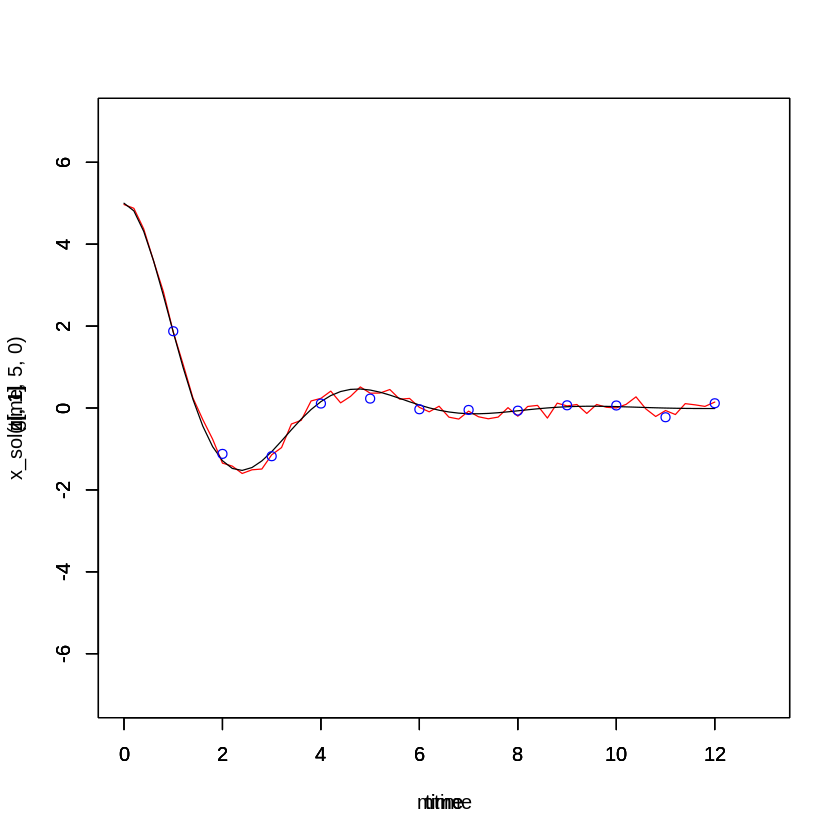

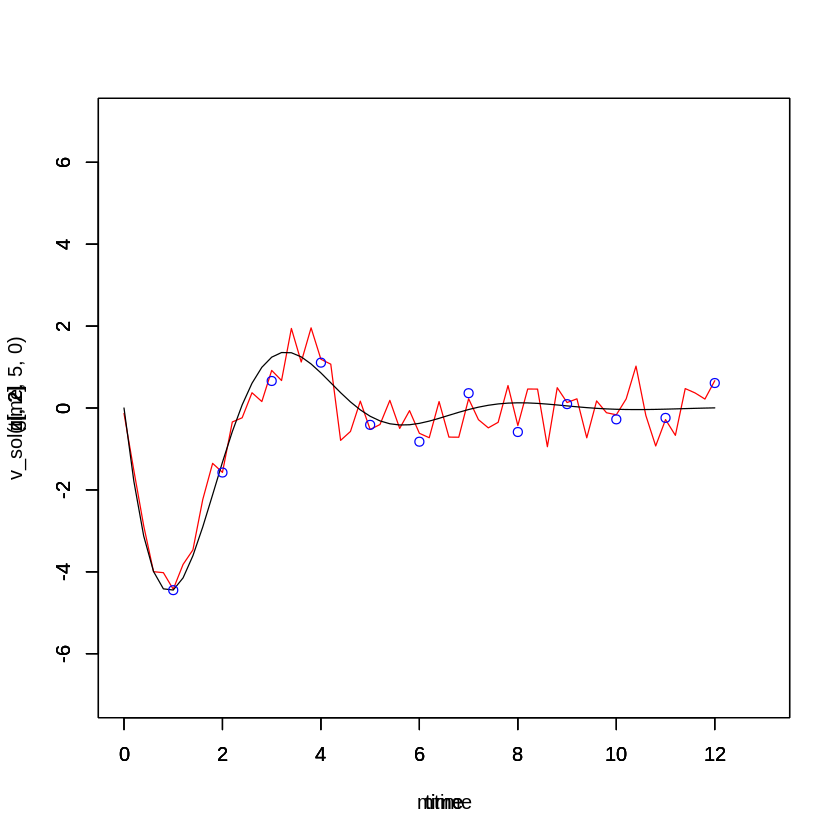

In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# TIME PARTITIONING
# Total time (seconds)
T = 12
# Total number of measurements
Nm = 12
# Number of timesteps between measurements
npm = 5
# number of time intervals
N = Nm * npm
# number of total time nodes
Np = N + 1
# length of timestep (seconds)
dt = T/N
# length of measurement step (seconds)
dm = T/Nm
# time partition
time = seq(0,T,by=dt)
# measurement partition
mtime = seq(dm, T, by=dm)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# physical parameters and state equation solutions
# mass of pedulum (kg)
m = 1
# air resistance constant
b = 1
# spring constant
k = 2

# functions for continious solution for (k=2, b=1 ,m=1)
x_sol <- function(t, x0, v0)
{
  x = 2 * v0 * exp(-t/2)*sin(sqrt(7)*t/2)/sqrt(7) + 1/7*x0*exp(-t/2)*(7*cos(sqrt(7)*t/2) + sqrt(7)*sin(sqrt(7)*t/2))
  return(x)
}
v_sol <- function(t, x0, v0)
{
v = - (4 * x0 *exp(-t/2) * sin(sqrt(7)*t/2))/sqrt(7) + 1/7 * v0 * exp(-t/2) * (7*cos(sqrt(7)*t/2) - sqrt(7)*sin(sqrt(7)*t/2))
return(v)
}
# system of equations
A = array(c(0 , -k/m, 1, -b/m), dim=c(2,2))
# identity matrix
I = array(c(1,0,0,1), dim=c(2,2))
# discrete system state equation matrix (Rk something)
F = I + A*dt + ((A*dt)%^%2)/4 + ((A*dt)%^%3)/6
FT = aperm(F)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# generate measurements
# velocity perterbation variance matrix
VP_sigma = array(c(0,0,0,.3), dim=c(2,2))
# variance in displacement measurements
xm_var = .01
# variance in velocity measurements
vm_var = .01
# estimate of Q matrix
Q = F%*%VP_sigma%*%FT
# White noise samples
w = rmvnorm(n=Np, mean=c(0,0), sigma=Q)
# Measurement covariance matrix
R = array(c(xm_var, 0, 0, vm_var), dim=c(2,2))
# measurement noise samples
r = rmvnorm(n=Nm, mean=c(0,0), sigma=R)
# ground truth values
g = array(dim=c(Np,2))
# measurement values
z = array(dim=c(Nm,2))

ind = 1
m_ind = 1
for (t in time){
  g[ind,1] = w[ind, 1] + x_sol(t, 5, 0)
  g[ind,2] = w[ind, 2] + v_sol(t, 5, 0)
  if (mtime[m_ind] == t){
    z[m_ind, ] = g[ind, ] + r[m_ind, ]
    m_ind = m_ind + 1
  }
  ind = ind + 1
}

xlims = c(0,T+1)
ylims = c(-7,7)
plot(time, g[,1], xlim=xlims, ylim=ylims, type="l", col="red")
par(new=TRUE)
plot(time, x_sol(time, 5, 0), type="l", xlim=xlims, ylim=ylims)
par(new=TRUE)
plot(mtime, z[,1], xlim=xlims, ylim=ylims, col="blue")
plot(time, g[,2], xlim=xlims, ylim=ylims, type="l", col="red")
par(new=TRUE)
plot(time, v_sol(time, 5, 0), type="l", xlim=xlims, ylim=ylims)
par(new=TRUE)
plot(mtime, z[,2], xlim=xlims, ylim=ylims, col="blue")


## Covariance Propagation Check

The above two plots show Generated ground truth, measurements , and the continious solution to the differential equation modeling motion.

Before we try to simulate integrating measurements as we time step along (run the kalman filter), as a sanity check we can look at the error bars for the covariance propation around the computed mean without any measurement integrated. 

We exepct the variances of all variables to shrink in time for the following reason. We know that our differential equation is stable. Where stability means that as $t\rightarrow\infty$, solutions with similar intial conditions stay in the same neighborhood as eachother. This is because the damping of the oscillation regardless of the our initial conditions forces us towards static equalibrium at 0. With this in mind we should become more confident as time goes on that our solution is $x(t\rightarrow\infty) = 0$, i.e. are variances shrink. The same would not be true for expontial growth for instance, because the smallest error in intial measurement with have greater effects as we move forward in time. The two below plots display that this is true.

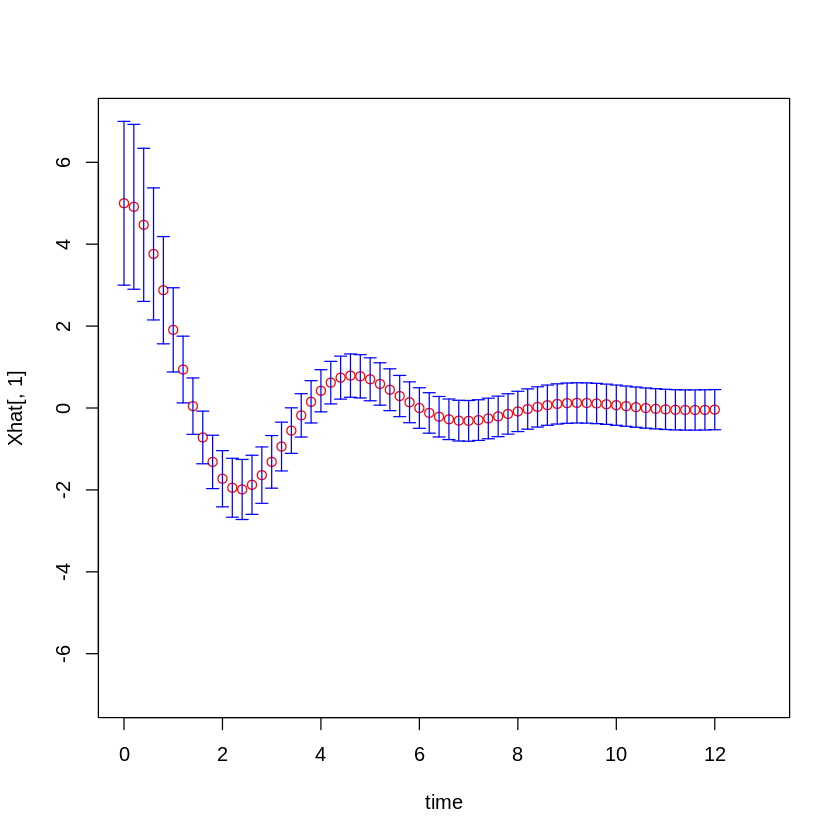

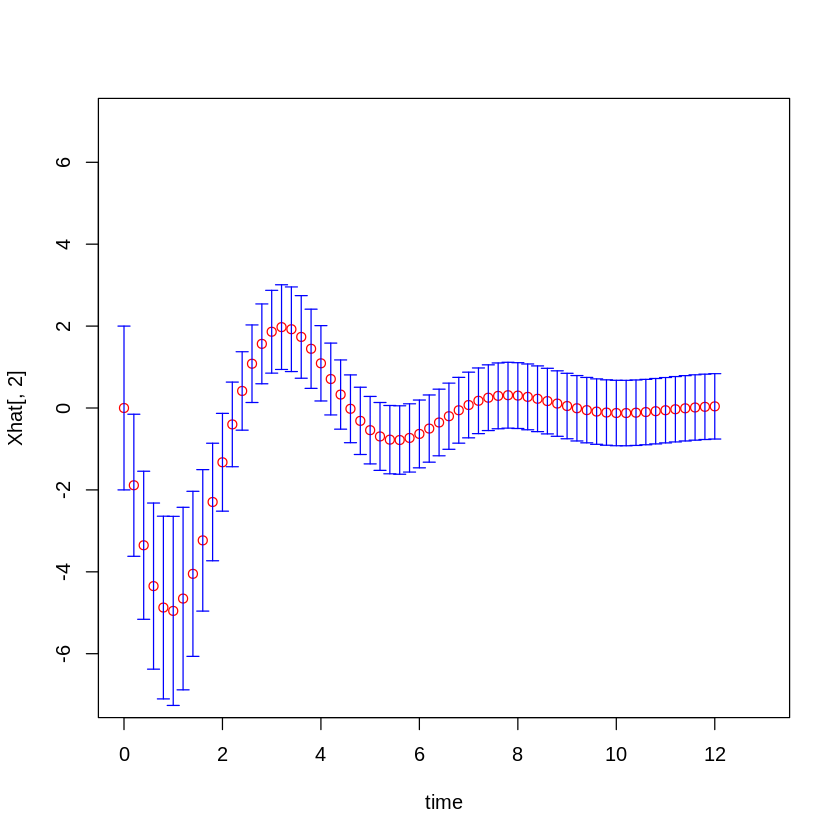

In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Plotting means and stds without merging measurements

# mean vector
Xhat = array(c(5,0), dim=c(Np, 2))
# covariance vector
P = array(c(2, 0,0,2), dim = c(Np, 2, 2))

for (i in 2:Np)
{
  Xhat[i, ] = F%*%Xhat[i-1, ]
  P[i, , ] = F%*%P[i-1, , ]%*%FT + Q
}

bottom = Xhat[, 1] - P[ ,1 ,1]
top = Xhat[,1] + P[, 1, 1]
plot(time, Xhat[ ,1], xlim = xlims, ylim=ylims, col="red")
par(new=TRUE)
arrows(time, bottom, time, top, ,length = .05, angle=90,code=3, col="blue")

bottom = Xhat[, 2] - P[ ,2 ,2]
top = Xhat[,2] + P[, 2, 2]
plot(time, Xhat[ ,2], xlim = xlims, ylim=ylims, col="red")
par(new=TRUE)
arrows(time, bottom, time, top, ,length = .05, angle=90,code=3, col="blue")

## Kalman Filter for Damped Oscillator

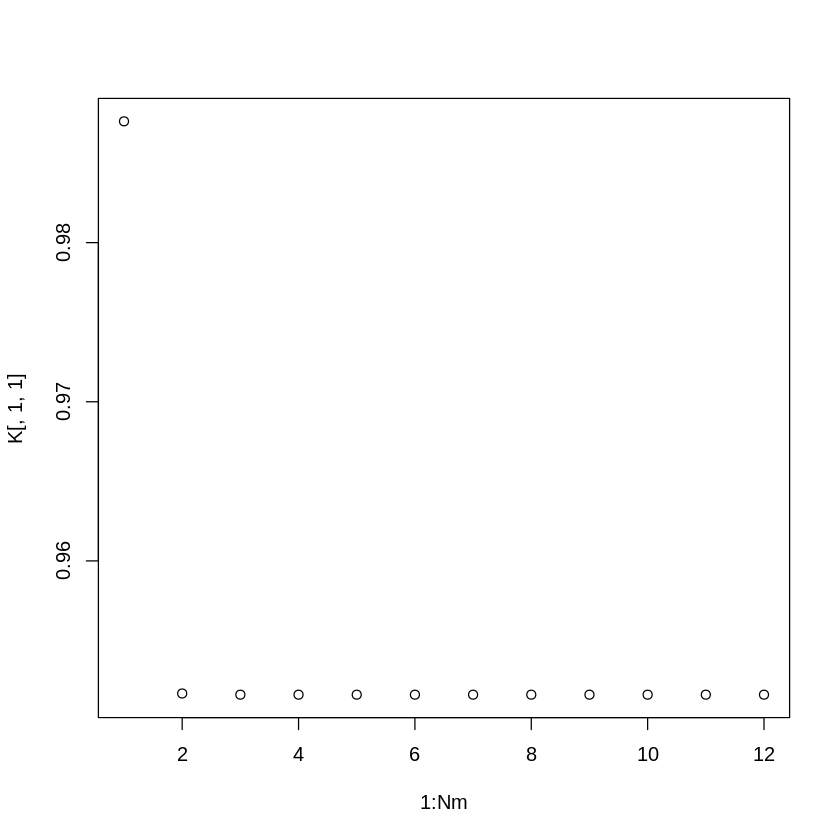

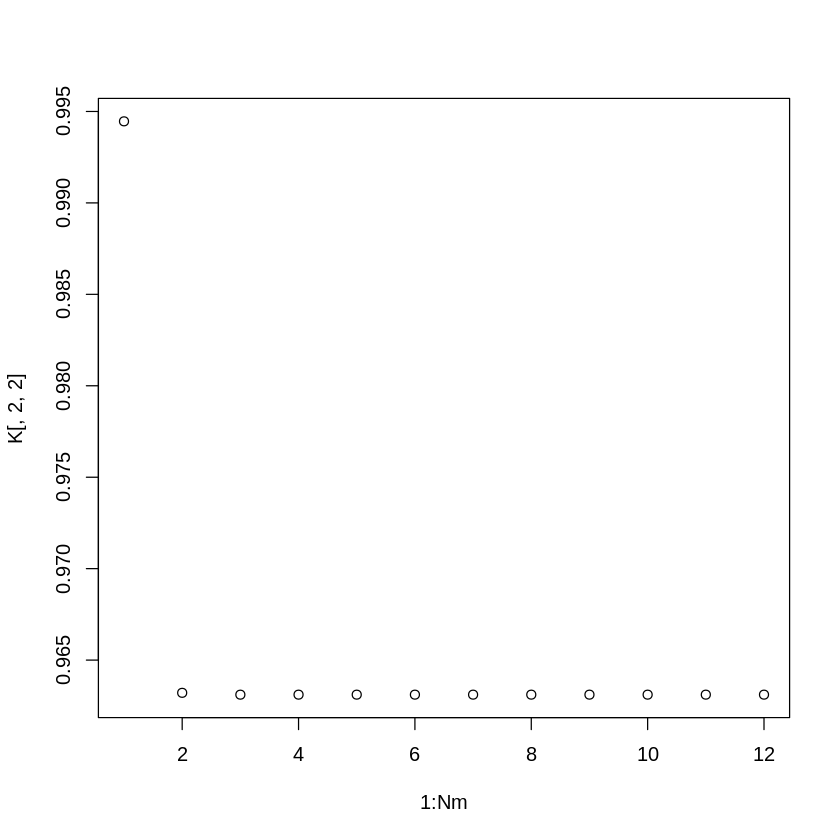

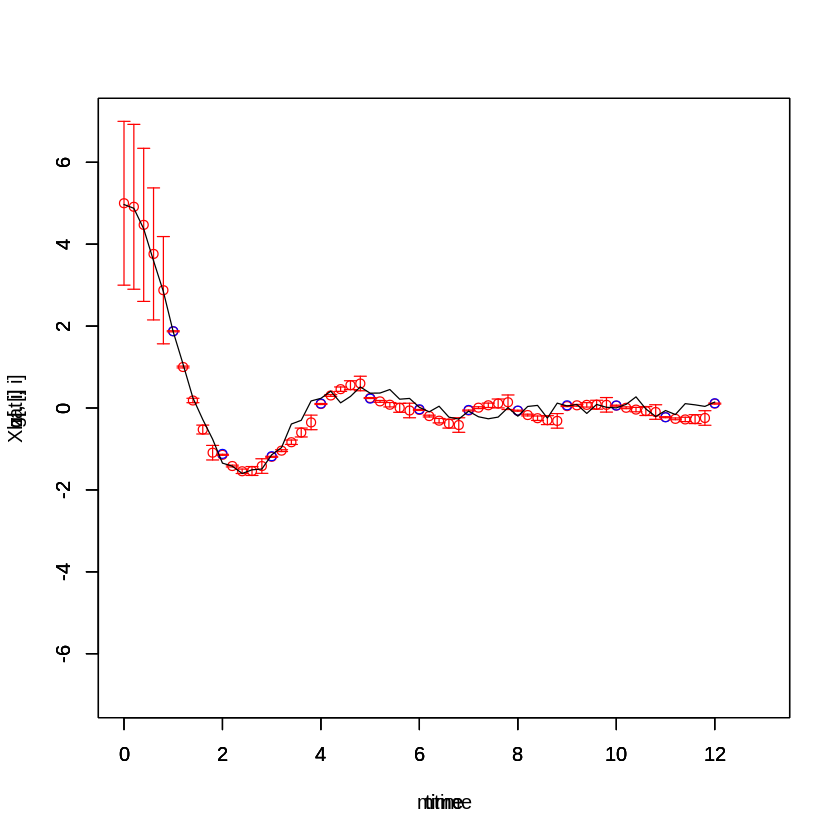

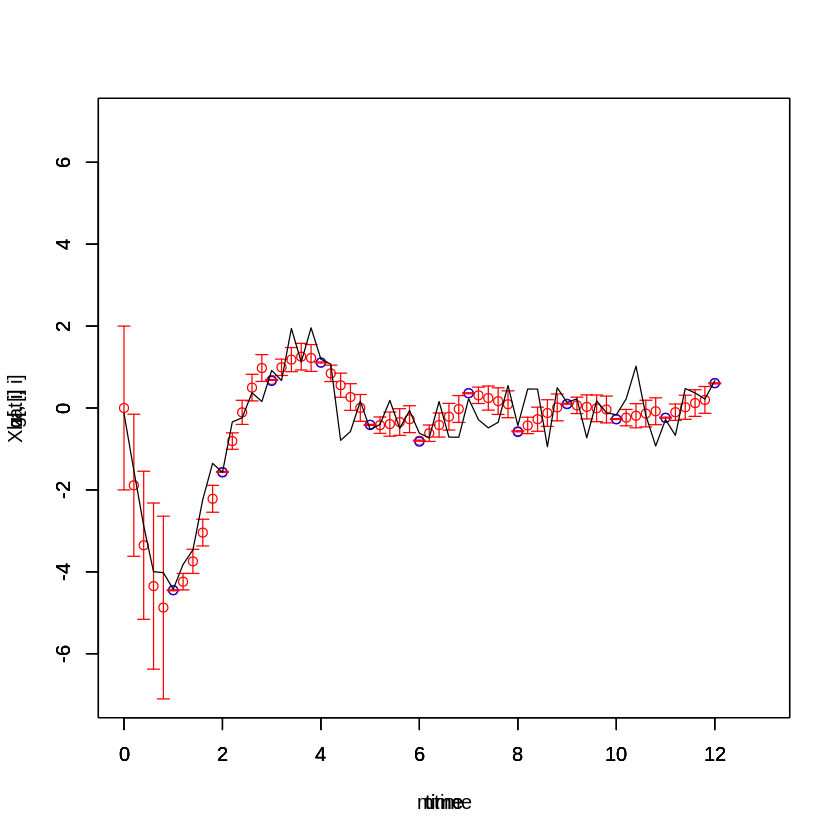

In [ ]:
# mean vector
Xhat = array(c(5,0), dim=c(Np, 2))
#
Xhat_no_m = array(c(5,0), dim=c(Np, 2))
# covariance vector
P = array(c(2, 0,0,2), dim = c(Np, 2, 2))
# measurement restriction operator
H = array(c(1,0,0,1), dim = c(2,2))
HT = aperm(H)
# Kalman Gain matrices
K = array(dim= c(Nm, 2,2))
m_ind = 1
for (i in 2:Np)
{
  # estimate
  Xhat[i, ] = F%*%Xhat[i-1, ]
  Xhat_no_m[i, ] = F%*%Xhat_no_m[i-1, ]
  P[i, , ] = F%*%P[i-1, , ]%*%FT + Q

  if (mtime[m_ind] == time[i]){
    # measurement merging
    K[m_ind, , ] = P[i, , ] %*% HT %*% solve(H %*% P[i, , ] %*% HT + R)
    Xhat[i,] = Xhat[i,] + K[m_ind, ,] %*% (z[m_ind, ] - H %*% Xhat[i,])
    P[i, , ] = (I - K[m_ind, , ]%*%H)*P[i, , ]
    m_ind = m_ind + 1
  }
}

plot(1:Nm, K[ ,1, 1])
plot(1:Nm, K[ ,2, 2])
for (i in 1:2){
bottom = Xhat[, i] - P[ ,i ,i]
top = Xhat[,i] + P[, i, i]
plot(time, Xhat[, i], col="red", xlim=xlims, ylim=ylims)
par(new=TRUE)
plot(mtime, z[,i], col="blue", xlim=xlims, ylim=ylims)
par(new=TRUE)
arrows(time, bottom, time, top, ,length = .05, angle=90,code=3, col="red")
par(new=TRUE)
plot(time, g[, i], type="l", xlim=xlims, ylim=ylims)
}

## Error Anaylsis

As a quick error anaylsis, I compute an $\mathcal{l}^2$ error over every timestep, between the pure state-space simulation, and the kalman filter system to compare.

\begin{gather}
  error = \frac{\sum_{i=0}^{Np} (\hat{x}_i - g_i)^T(\hat{x}_i - g_i)}{Np}
\end{gather}

Where $g_i$ is the generated "ground truth" at timestep $i$.


In [ ]:
error_kalman = 0
error_state_sys = 0

for (i in 1:Np)
{
  error_kalman = error_kalman + ((Xhat[i, ] - g[i, ])%*%(Xhat[i, ] - g[i, ]))[1]
  error_state_sys = error_state_sys + ((Xhat_no_m[i, ] - g[i, ])%*%(Xhat_no_m[i, ] - g[i, ]))[1]
}

error_kalman/Np
error_state_sys/Np

[1] 0.3157073

[1] 0.4141595

# Extended Kalman Filter for the SIR model with Generated Data

In the next section it is useful to refer to the SI part of the system as:

\begin{gather}
  F(S,I,R) = \begin{bmatrix}
          -\beta IS\\
          \beta IS - \gamma I\\
          \end{bmatrix}
\end{gather}

and each component as $F_S$, and $F_I$.

Now that we have a linear filter, we can attempt a filter on the non-linear SIR system. The main issue with the previously defined filter equations is that the covariance propagation equation doesn't work for a non-linear verision of $\Phi$. This can be addressed by linearizing the discrete state transition equation.

First, to derive the discrete state transition equation we can apply euler to the continious system of equations which yields:
\begin{gather}
\Phi(S_{t-1}, I_{t-1}) = 
\begin{bmatrix}
  S\\
  I\\
\end{bmatrix}_t
=\begin{bmatrix}
\Delta t F_s + S_{t-1}\\
\Delta t F_I + I_{t-1}\\
\end{bmatrix}
\end{gather}

The easiest way around the covariance propgation problem is to linearize $\Phi$ by taking its taylor expansion and ignoring the third term onwards.
Then the taylor expansion of $\Phi(x)$  around $a$ is:
\begin{gather}
  \Phi(x) \approx \Phi(a) + J^\Phi(a)(x-a) + \frac{1}{2}(x-a)^TH^\Phi(x-a) \cdots\\
\end{gather}
Where $J^\Phi$ and $H^\Phi$ are the Jacobian and Hessian, and $x$ and $a$ are vectors of $I,S$ and $R$, values. Since we attempting to linearize $\Phi(x)$ we drop all of the terms after the second one so that:
\begin{gather}
  \phi(x) = \Phi(a) + 
  \begin{bmatrix}
  -\Delta t\beta I + 1 & - \Delta t \beta S\\
  \Delta t\beta I & \Delta t(\beta S - \gamma) + 1\\
  \end{bmatrix}
  (x - a)
\end{gather}


Our new scheme is then to update our state mean using $\Phi$, and the state-covariance using $J_\Phi$. That is the first and second filter equations are now:

\begin{gather}
  \hat{X}_{i|j} = \Phi(\hat{X}_{i-1|j})\\
  P_{i,j} = J^\Phi_{i-1} P_{i-1,j} [J^\Phi_{i-1}]^T\\
\end{gather}

So far we have only delt with $\hat{S}$ and $\hat{I}$. To compute $\hat{R}$ at any time $t$, I just use: 

$$\hat{R} = 1 - \hat{S} - \hat{I}$$

and to compute the variance of $\hat{R}$ at any time we can use:

$$\sigma^2_R = \sigma^2_S + \sigma^2_I + 2\sigma^2_{IR}$$

where $\sigma^2_{IR}$ is the covariance of $\hat{I}$ and $\hat{R}$. All these quatities are avaliable assuming we first do the $\hat{S}$ and $\hat{I}$ computations.


## Ad-Hoc construction of $Q$ and $R$

The construction of $Q$ and $R$ are both at least in my case Ad-Hoc. I would have to do research into error anaylsis of the SIR model against real world pandemics to construct a more informed $Q$. And a little bit more can be said about $R$, but statistics about false positives and negatives need to used (I try to do this with the real data set I use later).

To construct $Q$, I use the same trick I did with the linear system above, but make the assumption of a pertbation in $I$ with variance $\sigma_{Ip}^2$.

For the $R$ matrix we can note that if we miss count the infected population we necessarly miss count the suspetiable population the opposite direction, so our $R$ matrix will have negative covariances. We also assume that the false-positives approximately balance out false-negatives so that the variances are approximately the same.


We can first look at what happens when propagating state and covariance without merging any measurements.



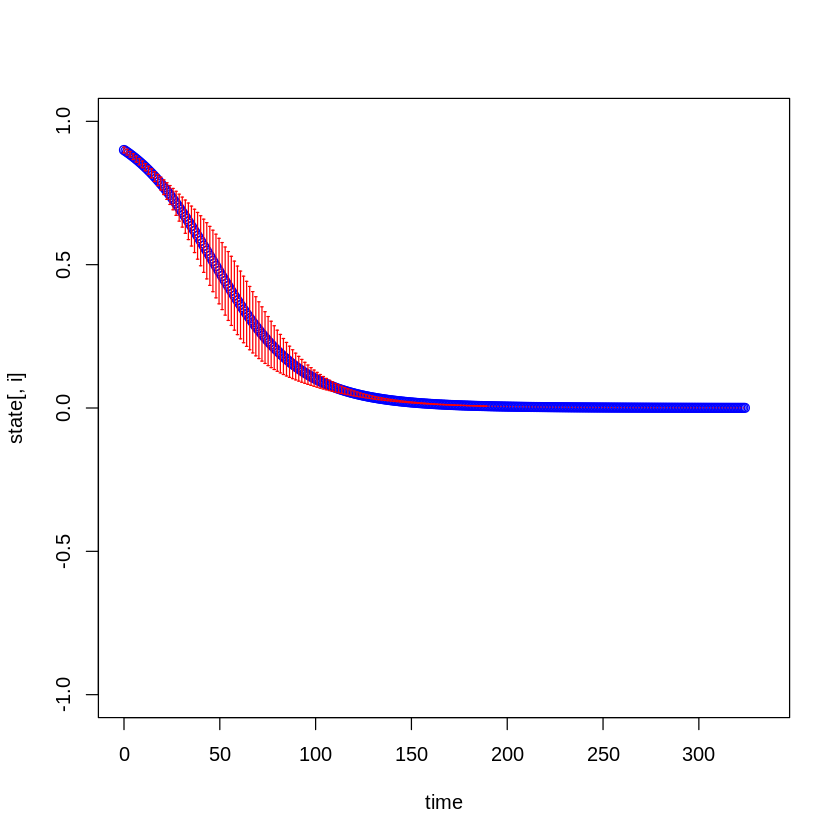

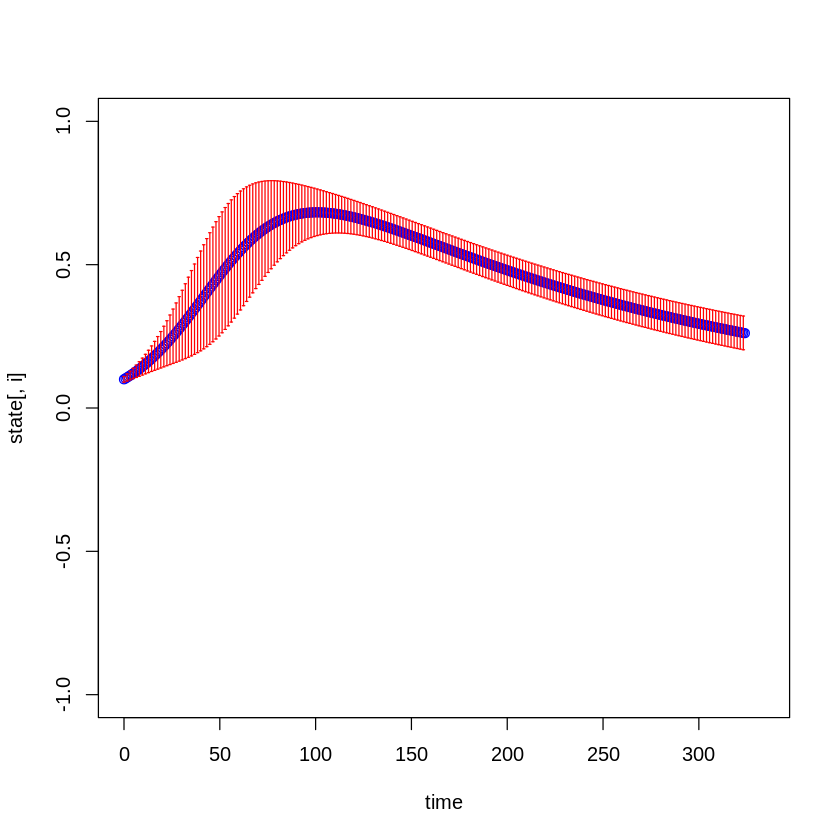

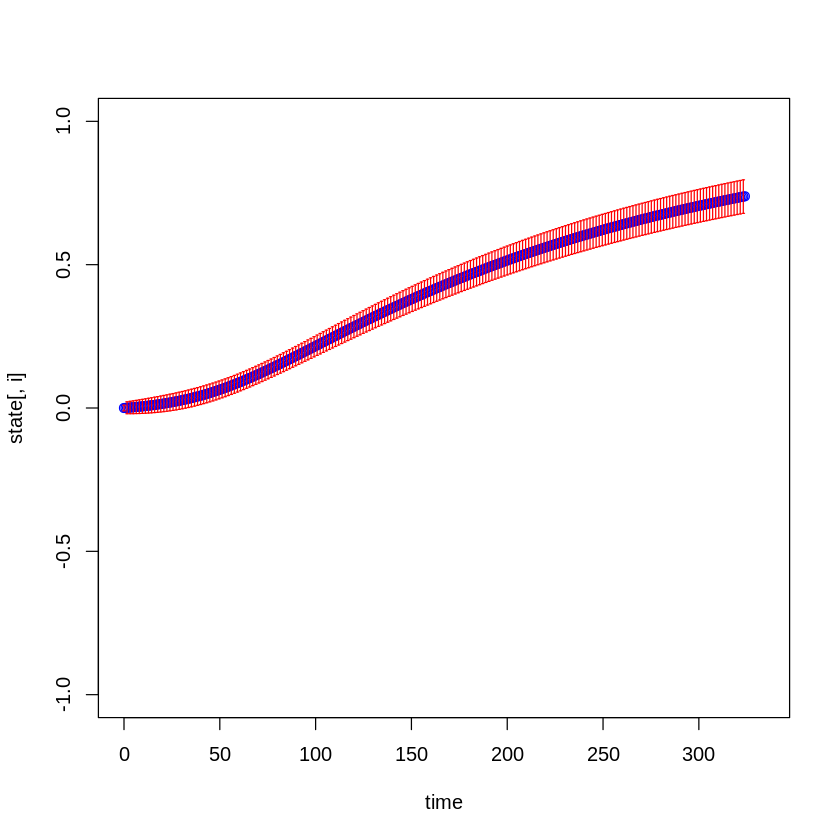

In [ ]:
options(warn=-1)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# time partitioning
# Total time (days)
T = 324
# Total number of measurements
Nm = T/4
# Number of timesteps between measurements
npm = 5
# number of time intervals
N = Nm * npm
# number of total time nodes
Np = N + 1
# length of timestep (Days)
dt = T/N
# length of measurement step (Days)
dm = T/Nm
# time partition
time = seq(0,T,by=dt)
# measurement partition
mtime = seq(dm, T, by=dm)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# physical parameters and state equation solutions
# rate of contacts (1/)
beta = .05
# rate of recovery
gamma = .005
# rate of change equations (state is vector of S,I,R)
Fd <- function(state, beta, gamma)
{
  return (c(-beta*state[1]*state[2],beta*state[1]*state[2] - gamma*state[2]))
}
# discrete dynamical system (eulers method)
Phi <- function(state, beta, gamma, dt)
{
  return(dt*Fd(state, beta, gamma) + state)
}
# Jacobian
J <- function(state,beta,gamma,dt)
{
return (array(c(- dt * beta * state[2] + 1, dt*beta*state[2],
                -dt * beta * state[1], dt*(beta*state[1] - gamma) + 1), dim=c(2,2)))
}


#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# data, state, and covariance initialization 
# ground truth vector to be filled
g = array(dim=c(Np,3))
# measurement vector to be filled
z = array(dim=c(Nm,3))
# state vectors
state = array(dim=c(Np,3))
# intial state
state[1,] = c(.9,.1,0.0)
# covariance matricies  
P = array(dim=c(Np,3,3))
# inital covariance
P[1, ,] = array(c(.01, 0, 0, 0, .01, 0, 0 ,0, .01), dim=c(3,3))
# infected perterbation
I_pert = .0005
# perterbation matrix
I_pertM = array(c(0,0,0, I_pert), dim=c(2,2))
# measurement error in suseptiable
merr_s = .0001
# measurment error in infected
merr_i = .0001
# measurement covariance matrix
R = array(c(merr_s,-.99*(merr_s)*(merr_i), -.99*(merr_s)*(merr_i), merr_i), dim=c(2,2))
r = rmvnorm(n=Nm, mean=c(0,0), sigma=R)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# simulation loop
#measurement index
m_ind = 1 
maxt = 0
for (i in 2:Np)
{
  # update state for plotting
  state[i,1:2] = Phi(state[i-1, 1:2], beta, gamma, dt)
  # update recovered
  state[i,3] = 1 - state[i,1] - state[i,2]
  # get jacobian
  Jt = J(state[i-1,1:2], beta, gamma, dt)

  Q = Jt%*%I_pertM%*%aperm(Jt)
  # generating noise samples
  q = rmvnorm(n=1, mean=c(0,0), sigma=Q)
  g[i, 1:2] = state[i,1:2] + q
  g[i,3] = 1 - g[i,1] - g[i,2]

  # get P for plotting
  P[i, 1:2 ,1:2] = Jt%*%P[i-1, 1:2, 1:2]%*%aperm(Jt) + Q
  P[i, 3, 3] = P[i, 1,1] + P[i, 2,2] + 2*P[i,1,2]

  if(time[i] == mtime[m_ind])
  {
    z[m_ind,1:2] = g[i, 1:2] + r[m_ind, ]
    z[m_ind, 3] = 1 - z[m_ind, 1] - z[m_ind, 2]
    m_ind = m_ind + 1
  }
}

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# plotting
for (i in 1:3)
{
xlims = c(0,T+10)
ylims = c(-1, 1)
bottom = state[, i] - P[ ,i ,i]
top = state[,i] + P[, i, i]

plot(time, state[,i], col="blue", xlim=xlims, ylim=ylims)
par(new=TRUE)
#plot(time, g[,i], col="red", xlim=xlims, ylim=ylims, type="l")
#par(new=TRUE)
#plot(mtime, z[,i], col="green", xlim=xlims, ylim=ylims, type="l")
arrows(time[c(TRUE,FALSE)], bottom[c(TRUE,FALSE)], time[c(TRUE,FALSE)], top[c(TRUE,FALSE)],length = .01, angle=90,code=3, col="red")

}

The error bars on the above graph were intially concering to me since since after the diease has moved through a population we still have uncertianty in the recovered and infected populations as $t\rightarrow \infty$.

Looking closer at covariance propgation equation and $J^\Phi$, I believe this is a product of linearization, for a more full explanation see appendix B. 

# Kalman  Filter Loop

[1] 0.8652941

[1] 0.4781805

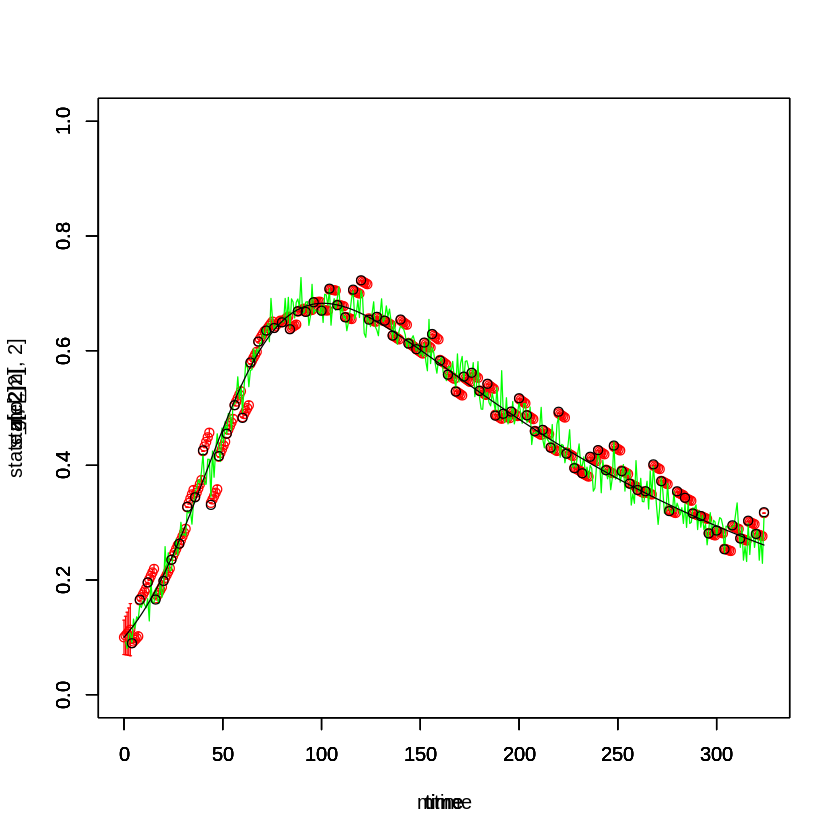

In [ ]:

m_ind = 1
H = array(c(1,0,0,1), dim=c(2,2))
K = array(dim=c(Nm, 2, 2))
state_no_m = array(dim=c(Np,3))
# intial state
state_no_m[1,] = c(.9,.1,0.0)
for (i in 2:Np)
{
  # estimate state
  state[i,1:2] = Phi(state[i-1, 1:2], beta, gamma, dt)
  state_no_m[i,1:2] = Phi(state_no_m[i-1, 1:2], beta, gamma, dt)
  state_no_m[i,3] = 1 - state_no_m[i,1] - state_no_m[i,2]
  state[i,3] = 1 - state[i,1] - state[i,2]
  # get jacobian and Q
  Jt = J(state[i-1,1:2], beta, gamma, dt)
  Q = Jt%*%I_pertM%*%aperm(Jt)
  # estimate covariance
  P[i, 1:2 ,1:2] = Jt%*%P[i-1, 1:2, 1:2]%*%aperm(Jt) + Q
  P[i, 3, 3] = P[i, 1,1] + P[i, 2,2] + 2*P[i,1,2]
  if (mtime[m_ind] == time[i]){
    # measurement merging
    # kalman gain
    K[m_ind, , ] = P[i, 1:2, 1:2] %*% HT %*% solve(H %*% P[i, 1:2, 1:2] %*% HT + R)
    # state merge
    state[i,1:2] = state[i,1:2] + K[m_ind, ,] %*% (z[m_ind, 1:2] - H %*% state[i,1:2])
    state[i,3] = 1 - state[i,1] - state[i,2]
    # covariance merge
    P[i, 1:2, 1:2] = (I - K[m_ind, , ]%*%H)*P[i, 1:2, 1:2]
    P[i, 3, 3] = P[i, 1,1] + P[i, 2,2] + 2*P[i,1,2]
    m_ind = m_ind + 1
  }
}

xlims = c(0,T)
ylims = c(0, 1)
plot(time, state[,2], col="red", xlim=xlims, ylim=ylims)
bottom = state[, 2] - 3*P[ ,2 ,2]
top = state[,2] + 3*P[, 2, 2]
arrows(time, bottom, time, top,length = .01, angle=90,code=3, col="red")
par(new=TRUE)
plot(time, g[,2], xlim=xlims, ylim=ylims, col="green", type='l')
par(new=TRUE)
plot(mtime, z[,2], xlim=xlims, ylim=ylims)
par(new=TRUE)
plot(time, state_no_m[,2], type="l", xlim=xlims, ylim=ylims)

error_kalman = 0
error_state_sys = 0

for (i in 2:Np)
{
  #print(state[i, ])
  #print(g[i, ])
  error_kalman = error_kalman + ((state[i, ] - g[i, ])%*%(state[i, ] - g[i, ]))[1]
  error_state_sys = error_state_sys + ((state_no_m[i, ] - g[i, ])%*%(state_no_m[i, ] - g[i, ]))[1]
}
error_kalman/dt
error_state_sys/dt

As we can see the error calculation of simulations without measurements is worse. Varying the number of timesteps, and measurements per sample will effect the difference in errors (for instance trying on 4 measurements over time, gave me results that were better sometimes). But the main problem I believe with the lack of a difference in error, is because of our data generation method where samples of $Q$ are uncorrlated in time. That is if we measure an infected population higher than our model simulation predicts we would execept on the next timestep that it will probably still be above our simulation estimate (depedent on the length of timestep). This sort of corrilation is not built into our data generation. Our ground truth is produced by perturbing $\hat{x}$ by some uncorrilated amount with mean 0, and therefore our normal simulation mean should probably to better by just giving us back the mean. I hope that this will no be an issue on real data.

# Parameter Estimation and Prediction on a real Covid Dataset

Finally, we can used the Kalman Filter on real covid-19 data for measurements.

One option for data is to use positive Covid test results as measurements for the infected population. The problem with this is that it is a bias estimator, since people who are going to tested for covid usually suspect they having, mean it will probably be an over-estimate of the infected fraction.

As data I used https://covid19-projections.com/ estimates of infected people in Oregon every day of the pandemic till mid march of this year. They estimate the total number of infected people with the following equations:

\begin{gather}
Z^I_i = \text{confirmed-cases}(\frac{1500}{i + 50}(\text{positivity-rate})^.5 + 2
\end{gather}

More information on this estimte is at https://covid19-projections.com/estimating-true-infections-revisited/.
Assuming this is reasonable measurement of the infected population of Oregon, we can now reformulate the filter one more time.

One glaring issue is that $\beta$ and potentially $\gamma$ are unknown functions of time as well, otherwise we wouldn't get people able to get the multi-modal peaks of infection seen in the data below.



In [ ]:
 data = read.csv(file = '/content/covid_data2.csv')

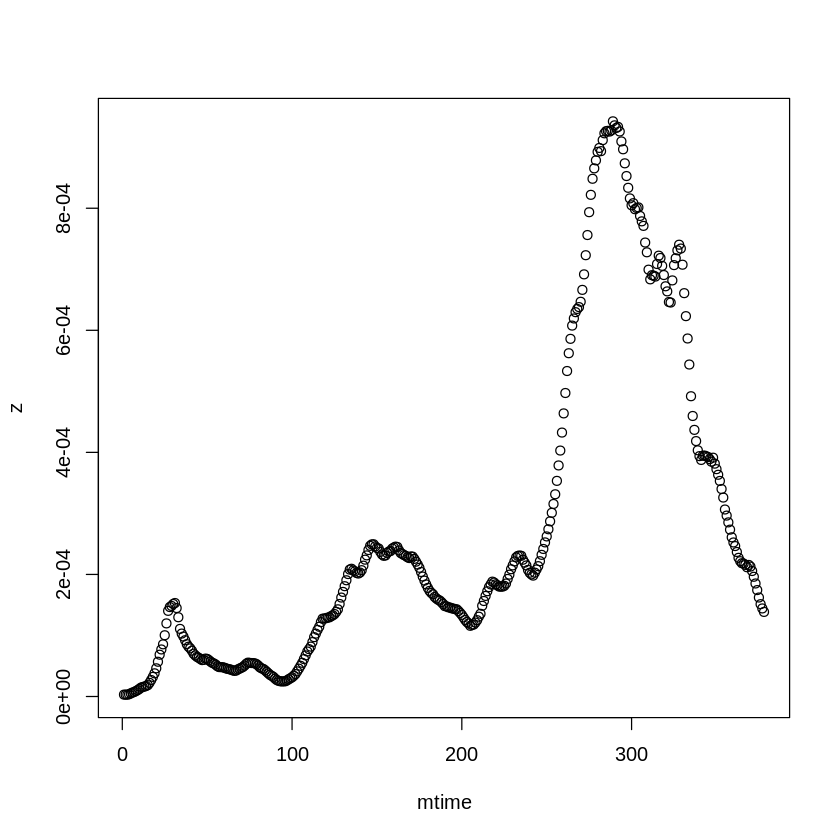

In [ ]:
# getting oregon data
data = data[order(as.Date(data$date, format="%Y-%m-%d")),]
or_data = data[which(data$state == 'OR'),]
pop_OR = 4237256
# infected population measurements
z = (or_data$new_infected_mean[1:378])/pop_OR

#sum(z)
# total number of days
T = length(z)
#plot(1:length(or_data$date), z)
Nm = T
# Number of timesteps between measurements
npm = 5
# number of time intervals
N = Nm * npm
# number of total time nodes
Np = N + 1
# length of timestep (Days)
dt = T/N
# length of measurement step (Days)
dm = T/Nm
# time partition
time = seq(0,T,by=dt)
# measurement partition
mtime = seq(dm, T, by=dm)
plot(mtime,z)



There are many ways to estimate $\beta$ and $\gamma$ in real time. One simply way is to add $\beta$ and $\gamma$ as state variables to our equations, but set their state evolution equations to zero, and only update them when we receive a measurement. The filter equations take the same form as before except that now we only have access measurements in $I$, therefore we have that:

\begin{gather}
H = \begin{bmatrix}
0 & 0 & 0\\
0 & 1 & 0\\
0 & 0 & 0\\
\end{bmatrix}
\end{gather}

We also have a static update of $\beta$ and $\gamma$ in $\Phi$, and $J^\Phi$

# Appendix B: long term behavior of covariance with linearization


We are using:

\begin{gather}
  P_{i,j} = J^\Phi_{i-1} P_{i-1,j}(J^\Phi_{i-1})^T + J^\Phi_{i-1}\begin{bmatrix}0&0\\0&\sigma_{Ip}\end{bmatrix}(J^\Phi_{i-1})^T
\end{gather}

Computing the second term gives:

\begin{gather}
\begin{bmatrix}
  (-\Delta t \beta S)^2\sigma_{Ip}^2 & (\Delta t (\beta S - \gamma) + 1)(-\Delta t \beta S)\sigma_{Ip}^2\\
  (\Delta t (\beta S - \gamma) + 1)(-\Delta t \beta S)\sigma_{Ip}^2 & ((\Delta t (\beta S - \gamma) + 1)^2 \sigma^2_{Ip}
\end{bmatrix}
\end{gather}